In [1]:
import os
import random
import cv2
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score         

import torch
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torch import optim, nn
from torch.optim import lr_scheduler
from torchvision import models

import albumentations as A
from albumentations.pytorch import transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')         

## Data preporation

Используем набор картинок, на котором уже вырезаны птицы и исправлена разметка

In [2]:
class BirdsDataset(Dataset):
    def __init__(self, ds_path: str, to_tensor: callable, cust_transforms=None):
        self.ds_path = ds_path
        # Store image path and its label
        self.imgs_path_list = [(os.path.join(self.ds_path, temp_folder, temp_img), temp_folder)
                               for temp_folder in os.listdir(self.ds_path) 
                               for temp_img in os.listdir(os.path.join(self.ds_path, temp_folder))]
        self.cust_transforms = cust_transforms
        self.to_tensor = to_tensor
    
    def __getitem__(self, ind: int):
        img_path, label = self.imgs_path_list[ind]
        
        raw_img = cv2.imread(img_path)
        
        prep_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
        
        if self.cust_transforms:
            prep_img = self.cust_transforms(image=prep_img)['image']
        
        return self.to_tensor(prep_img), int(label)
    
    def __len__(self):
        return len(self.imgs_path_list)

In [3]:
trans = A.pytorch.ToTensorV2()
to_tensor = lambda x: trans(image=x)['image']

temp_ds = BirdsDataset('/kaggle/input/birds-ds/preprocessing_results', to_tensor)

In [4]:
temp_ds[0]

(tensor([[[158, 161, 163,  ..., 170, 167, 170],
          [165, 175, 182,  ..., 193, 193, 190],
          [154, 160, 163,  ..., 200, 205, 200],
          ...,
          [168, 166, 167,  ..., 158, 178, 181],
          [167, 168, 170,  ..., 172, 167, 168],
          [160, 165, 168,  ..., 167, 165, 159]],
 
         [[138, 141, 143,  ..., 156, 153, 151],
          [141, 151, 159,  ..., 174, 171, 166],
          [123, 129, 134,  ..., 168, 169, 164],
          ...,
          [130, 130, 131,  ..., 136, 157, 167],
          [135, 136, 139,  ..., 151, 148, 152],
          [131, 136, 140,  ..., 149, 147, 143]],
 
         [[ 67,  72,  82,  ...,  49,  48,  49],
          [ 79,  91, 105,  ...,  72,  72,  70],
          [ 77,  85,  94,  ...,  83,  85,  80],
          ...,
          [ 59,  56,  55,  ...,  51,  78,  94],
          [ 60,  59,  57,  ...,  58,  56,  64],
          [ 53,  56,  56,  ...,  51,  49,  47]]], dtype=torch.uint8),
 7)

## Fix Randomness
Нужно зафиксировать различные источники случайности, для воспроизводимости результатов исследования

In [5]:
RANDOM_SEED = 1234
loader_gen = torch.Generator()

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

        
def config_randomness():
    global loader_gen
    
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    loader_gen = torch.Generator()
    loader_gen.manual_seed(RANDOM_SEED)
    
    torch.cuda.manual_seed_all(RANDOM_SEED)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Training pipeline

In [6]:
def train(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, optimizer: optim.Optimizer, loss, epoch_num: int, scheduler=None):
    train_loss_history = list()
    val_loss_history = list()
    
    val_acc_history = list()
    val_metric_history = list()
    
    model.to(device)
    
    for epoch_ind in range(epoch_num):
        temp_epoch_loss = 0
        temp_val_loss = 0
        
        # Train model
        model.train()
        
        for img_batch, target_batch in train_loader:              
            img_batch = img_batch.type(torch.FloatTensor).to(device)
            target_batch = target_batch.type(torch.LongTensor).to(device)
            
            # Forward pass
            model_pred = model(img_batch)
            
            cur_loss = loss(model_pred, target_batch)
            
            # Backward pass
            optimizer.zero_grad()
            cur_loss.backward()
            optimizer.step()
            
            #print(cur_loss)
            temp_epoch_loss += cur_loss.item()
            #print(temp_epoch_loss)
            torch.cuda.empty_cache()
            
        if scheduler:
            scheduler.step()
        # Save train loss    
        train_loss_history.append(temp_epoch_loss / len(train_loader))
        
        # Validate model
        model.eval()
        
        model_answers_list = list()
        model_probs_list = list()
        true_labels_list = list()
        
        for img_batch, target_batch in val_loader:
            img_batch = img_batch.type(torch.FloatTensor).to(device)
            target_batch = target_batch.type(torch.LongTensor).to(device)
            
            model_pred = model(img_batch).detach()
            
            val_loss = loss(model_pred, target_batch)
            
            temp_val_loss += val_loss.item()
            
            model_answers_list.extend(list(torch.argmax(model_pred, dim=1).cpu().numpy()))
            model_probs_list.extend(nn.functional.softmax(model_pred.cpu(), dim=1).numpy())
            true_labels_list.extend(list(target_batch.cpu().numpy()))
            
            torch.cuda.empty_cache()
        
        val_acc_history.append(accuracy_score(true_labels_list, model_answers_list))
        val_loss_history.append(temp_val_loss / len(val_loader))
        
        model_probs_matrix = model_probs_list[0]
        
        for item in model_probs_list[1:]:
            model_probs_matrix = np.vstack((model_probs_matrix, item))      
        
        val_metric_history.append(f1_score(true_labels_list, model_answers_list, average='macro'))
        
        print(f'------------ Epoch #{epoch_ind + 1} Train loss: {round(train_loss_history[-1], 6)} Val loss: {round(val_loss_history[-1], 6)} ' + \
              f'F1: {round(val_metric_history[-1], 4)} ACC: {round(val_acc_history[-1], 4)} DIFF: {round(train_loss_history[-1] - val_loss_history[-1], 4)}   ------------')

    return train_loss_history, val_loss_history, val_acc_history, val_metric_history

In [7]:
class LogitAdjustmentLoss(nn.Module):
    def __init__(self, base_probs, tau=1.0):
        super().__init__()
        self.base_probs = base_probs
        self.tau = tau

    def forward(self, inputs, targets):
        logits = inputs + torch.log(torch.pow(self.base_probs, self.tau) + 1e-12)
        return nn.functional.cross_entropy(logits, targets)

In [8]:
base_model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [9]:
class CBAMBlock(nn.Module):
    def __init__(self, in_channels: int, hidden_linear_size: int):
        super().__init__()
        
        # Channel wise layers init
        self.max_pool = nn.AdaptiveMaxPool2d(output_size=(1, 1))
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.shared_linear = nn.Sequential(
            nn.Linear(in_channels, hidden_linear_size),
            nn.ReLU(),
            nn.Linear(hidden_linear_size, in_channels),
        )
        
        # Spatial wise layers init
        self.channel_max_pool = nn.MaxPool3d((in_channels, 1, 1), stride=1)
        self.channel_avg_pool = nn.AvgPool3d((in_channels, 1, 1), stride=1)
        
        self.spatial_conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=(7, 7), padding=3)
        
    def forward(self, X: torch.Tensor):
        
        # Channel wise attention
        max_pooled_X = self.max_pool(X) # BxCx1x1
        avg_pooled_X = self.avg_pool(X) # BxCx1x1
        
        max_pooled_X = max_pooled_X.squeeze() # BxC
        avg_pooled_X = avg_pooled_X.squeeze() # BxC
        
        max_featured_X = self.shared_linear(max_pooled_X) # BxC
        avg_featured_X = self.shared_linear(avg_pooled_X) # BxC
        
        channel_attention_vect = torch.sigmoid(max_featured_X + avg_featured_X) # BxC
        
        channel_attention_vect = channel_attention_vect.unsqueeze(2).unsqueeze(3) # BxCx1x1
        
        modified_X = X * channel_attention_vect
        
        # Spatial wise attention
        max_pooled_X = self.channel_max_pool(modified_X)
        avg_pooled_X = self.channel_avg_pool(modified_X)
        
        concatenated_X = torch.cat([max_pooled_X, avg_pooled_X], dim=1)
        spatial_attention_map = torch.sigmoid(self.spatial_conv(concatenated_X))
        
        return modified_X * spatial_attention_map

Определим несколько функций, которые будут реализовывать логику внедрения CBAM блоков в предобученные архитектуры PyTorch

In [10]:
def get_effnet_b2_modified(temp_base_model: nn.Module):
    # Unfreeze backbone model
    for item in temp_base_model.parameters():
        item.requires_grad = True
    
    # Add CBAM blocks
    counter = 0
    for item in temp_base_model.features[1:-1]:
        if counter % 2:
            in_channels_count = item[-1].block[-1][-1].num_features
            item.add_module('CBAM', CBAMBlock(in_channels_count, in_channels_count * 3 // 4))
            item.CBAM.requires_grad = True
            
        counter += 1
        
    return temp_base_model

def get_resnet_152_modified(temp_base_model: nn.Module):
    
    # Unfreeze backbone model
    for item in temp_base_model.parameters():
        item.requires_grad = False
    
    for item in range(1, 5):
        temp_layer = temp_base_model.__getattr__(f'layer{item}')
        in_channels_count = temp_layer[-1].bn3.num_features
        temp_layer.add_module('CBAM', CBAMBlock(in_channels_count, in_channels_count * 3 // 4))
        
    return temp_base_model

In [11]:
config_randomness()

batch_size = 32
epoch_num = 15

lr = 1e-3
classifier_lr = 1e-4
backbone_lr = 1e-5

train_transforms_list = A.Compose(
    [
        A.augmentations.geometric.resize.Resize(224, 224),
        A.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HorizontalFlip(),
        #A.Rotate(15), #[0, 10, 15]
        #A.GaussianBlur(5), #[],
        #A.RandomBrightnessContrast(),
    ]
)

valid_transforms_list = A.Compose(
    [
        A.augmentations.geometric.resize.Resize(224, 224),
        A.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

# Define dataset
trans = A.pytorch.ToTensorV2()
to_tensor = lambda x: trans(image=x)['image']

train_data = BirdsDataset('/kaggle/input/birds-ds/preprocessing_results', to_tensor, train_transforms_list)

# Create a stratified train test split
ind_list = list()
labels_list = list()

for temp_ind in range(len(train_data)):
    ind_list.append(temp_ind)
    labels_list.append(train_data[temp_ind][1])
    
train_ind_list, valid_ind_list = train_test_split(ind_list, test_size=0.3, stratify=labels_list, random_state=RANDOM_SEED)

train_ds = Subset(train_data, train_ind_list)

# Turn off transforms
valid_dataset = deepcopy(train_data)
valid_dataset.cust_transforms = valid_transforms_list

valid_ds = Subset(valid_dataset, valid_ind_list)

# Create sampler with data upsampling function
uniq_labels_list, labels_count_list = np.unique(labels_list, return_counts=True)
class_weights = {uniq_labels_list[temp_ind]: sum(labels_count_list) / labels_count_list[temp_ind] for temp_ind in range(len(uniq_labels_list))}

train_ind_weight_list = [class_weights[labels_list[temp_ind]] for temp_ind in train_ind_list]
valid_ind_weight_list = [class_weights[labels_list[temp_ind]] for temp_ind in valid_ind_list]

w_train_sampler = WeightedRandomSampler(train_ind_weight_list, len(train_ind_weight_list), replacement=True, 
                                        generator=torch.Generator().manual_seed(RANDOM_SEED))
# w_valid_sampler = WeightedRandomSampler(valid_ind_weight_list, len(valild_ind_weight_list), replacement=True, 
#                                         generator=torch.Generator().manual_seed(RANDOM_SEED))

# Define Loss
loss = nn.CrossEntropyLoss()

# Calculate base probs on train dataset and use in LogitAdjustment loss 
#base_probs = [1 / item[1] for item in sorted(class_weights.items(), key=lambda x: x[0])]
#loss = LogitAdjustmentLoss(torch.FloatTensor(base_probs).to(device), tau=1.0)

# Get backbone model
backbone_model = deepcopy(base_model)
model = get_effnet_b2_modified(backbone_model)

model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(uniq_labels_list))

train_loader = DataLoader(train_ds, batch_size, num_workers=2, sampler=w_train_sampler, 
                          worker_init_fn=seed_worker, generator=loader_gen)
# train_loader = DataLoader(train_ds, batch_size, num_workers=2, shuffle=True, 
#                           worker_init_fn=seed_worker, generator=loader_gen)
val_loader = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2)    

CBAM_params_list = [temp_param[1] for temp_param in model.named_parameters() if 'CBAM' in temp_param[0]]
other_params_list = [temp_param[1] for temp_param in model.named_parameters() if 'CBAM' not in temp_param[0] and 'classifier' not in temp_param[0]]
classifier_params_list = [temp_param[1] for temp_param in model.named_parameters() if 'classifier' in temp_param[0]]

# Optimizer with different learning rate for different layers
optimizer = optim.Adam([
    {'params': CBAM_params_list, 'lr': lr},
    {'params': other_params_list, 'lr': backbone_lr},
    {'params': classifier_params_list, 'lr': classifier_lr},
], lr)

scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

torch.cuda.empty_cache()

In [12]:
%%time

train_loss_history, val_loss_history, val_acc_history, val_metric_history = train(model, train_loader, val_loader, 
                                                                                  optimizer, loss, epoch_num, scheduler)

------------ Epoch #1 Train loss: 3.941498 Val loss: 3.946363 F1: 0.0002 ACC: 0.0055 DIFF: -0.0049   ------------
------------ Epoch #2 Train loss: 3.915031 Val loss: 3.94162 F1: 0.008 ACC: 0.0221 DIFF: -0.0266   ------------
------------ Epoch #3 Train loss: 3.940551 Val loss: 3.943739 F1: 0.004 ACC: 0.011 DIFF: -0.0032   ------------
------------ Epoch #4 Train loss: 3.905638 Val loss: 3.925064 F1: 0.0325 ACC: 0.0331 DIFF: -0.0194   ------------
------------ Epoch #5 Train loss: 3.917435 Val loss: 3.921993 F1: 0.025 ACC: 0.0276 DIFF: -0.0046   ------------
------------ Epoch #6 Train loss: 3.88288 Val loss: 3.905257 F1: 0.02 ACC: 0.0387 DIFF: -0.0224   ------------
------------ Epoch #7 Train loss: 3.896364 Val loss: 3.909051 F1: 0.0176 ACC: 0.0331 DIFF: -0.0127   ------------
------------ Epoch #8 Train loss: 3.939215 Val loss: 3.909547 F1: 0.0274 ACC: 0.0331 DIFF: 0.0297   ------------
------------ Epoch #9 Train loss: 3.885351 Val loss: 3.916276 F1: 0.0087 ACC: 0.0221 DIFF: -0.030

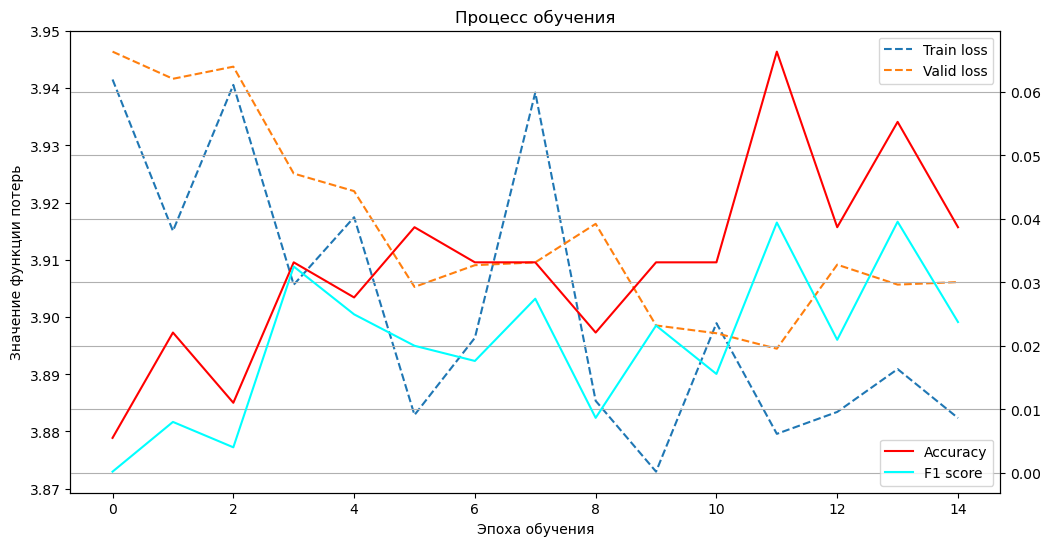

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.set_title('Процесс обучения')
ax.set_xlabel('Эпоха обучения')
ax.set_ylabel('Значение функции потерь')

ax.plot(train_loss_history, '--', label='Train loss')
ax.plot(val_loss_history, '--', label='Valid loss')
ax.legend()

sec_ax = ax.twinx()
sec_ax.plot(val_acc_history, label='Accuracy', color='red')
sec_ax.plot(val_metric_history, label='F1 score', color='cyan')

sec_ax.legend(loc='lower right')
sec_ax.grid()